In [1]:
from comet_ml import Experiment

import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from matplotlib.colors import LogNorm

from tqdm import tqdm

from modules.mrartemev_ganlib import gans
from modules.mrartemev_ganlib import nn as gans_nn

import torch
from torch import nn
import os


In [2]:
GPU_NUM = 1

In [3]:
cosmic = pd.read_csv('../data/raw/cosmic.csv.gz')
cosmic.head()

,Channel,ADC_ADC_Sig,ADC_ADC_bg,Board,Nhit,Asic_TDC0,Asic_ADC0,Asic_TOT0,Asic_TDC1,Asic_ADC1,...,Asic_TOT4,Asic_TDC5,Asic_ADC5,Asic_TOT5,Asic_TDC6,Asic_ADC6,Asic_TOT6,Asic_TDC7,Asic_ADC7,Asic_TOT7
0,41,56,0,3,1,-1,-1,-1,4884,56,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,14,83,0,15,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,4863,83,6,-1,-1,-1
2,15,43,0,34,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,4817,43,7
3,12,110,0,35,1,-1,-1,-1,-1,-1,...,7,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,12,224,0,56,1,-1,-1,-1,-1,-1,...,7,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)

c_cols = ['Channel', 'Board', 'ADC_ADC_Sig']
x_cols = list(set(cosmic.columns) - set(c_cols))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
dim = len(x_cols)
context_dim = len(c_cols)

prior = torch.distributions.MultivariateNormal(torch.zeros(64).to(device),
                                               torch.eye(64).to(device))
model = gans.WGAN_GP(dim, prior, base_network=gans_nn.MLP,
                     hidden_features=128, depth=5, context=context_dim
                    ).to(device)

# optimizer
gen_optimizer = torch.optim.Adam(model.generator.parameters(), lr=5e-5)
disc_optimizer = torch.optim.Adam(model.discriminator.parameters(), lr=5e-5)

gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_optimizer, 0.95)
disc_scheduler = torch.optim.lr_scheduler.ExponentialLR(disc_optimizer, 0.95)

In [14]:
from sklearn.preprocessing import QuantileTransformer

x_scaler = QuantileTransformer(n_quantiles=10000, output_distribution='normal', subsample=1000000, random_state=42)
c_scaler = QuantileTransformer(n_quantiles=10000, output_distribution='normal', subsample=1000000,  random_state=42)


In [15]:
from torch.utils.data import TensorDataset, DataLoader

def get_infinite_loader(loader):
    iter_loader = iter(loader)
    while True:
        try:
            yield next(iter_loader)
        except StopIteration:
            iter_loader = iter(loader)
            yield next(iter_loader)

train_dataloader = TensorDataset(torch.tensor(x_scaler.fit_transform(cosmic[x_cols])),
                                 torch.tensor(c_scaler.fit_transform(cosmic[c_cols])))
train_dataloader = DataLoader(train_dataloader, batch_size=128, shuffle=True, drop_last=True)
train_dataloader = get_infinite_loader(train_dataloader)

In [16]:
batch = next(train_dataloader)
x, context = [i.to(device).float() for i in batch]
gen_loss = model.calculate_loss_gen(x, context=context)
disc_loss = model.calculate_loss_disc(x, context=context)
gen_loss.mean().item(), disc_loss.mean().item()

(16.11202621459961, 5.2343034744262695)

In [17]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="richgans", workspace="maximartemev")


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/maximartemev/richgans/7822dfc8c49e4fa09ec5373dd18c3853
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     disc/lr [132]            : (6.036181600267522e-08, 5e-05)
COMET INFO:     gen/lr [132]             : (6.036181600267522e-08, 5e-05)
COMET INFO:     loss [315773]            : (-4.382468223571777, 5.529477596282959)
COMET INFO:     train/disc/loss [197440] : (-4.412642002105713, 0.3200421929359436)
COMET INFO:     train/gen/loss [197441]  : (-0.365499347448349, 5.611729621887207)
COMET INFO:   Parameters:
COMET INFO:   Uploads [count]:
COMET INFO:     environment details      : 1
COMET INFO:     figures [264]            : 264
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-pat

In [18]:
VAL_INTERVALS = 1500
GEN_UPDATES = 1
DISC_UPDATES = 15

In [19]:
def plot_compare(data):
    plt.figure(figsize=(20, 20))
    
    x_val = x_scaler.transform(data[x_cols])
    c_val = c_scaler.transform(data[c_cols])
    x_gen = model.generate(data.shape[0], torch.tensor(c_val, device=device).float()).detach().cpu().numpy()
    
    plot_ind = 0
    for ind, col in enumerate(x_cols):
        if 'ADC' in col or col == 'Nhit':
            plot_ind += 1
            plt.subplot(5, 2, plot_ind)
            _, bins, _ = plt.hist(x_val[:, ind], bins=50, alpha=0.6, label='Real', density=True)
            plt.hist(x_gen[:, ind], bins=bins, alpha=0.6, label='Generated', density=True)
            plt.grid()
            plt.legend()
            plt.title(col)

In [20]:
mc_noct = pd.read_csv('../data/raw/mcmc_noxtalk.csv.gz', nrows=100000)
mc_ct = pd.read_csv('../data/raw/mcmc_xtalk.csv.gz', nrows=100000)


  2%|▏         | 15000/1000000 [52:00<52:58:53,  5.16it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  2%|▏         | 16500/1000000 [57:36<55:52:25,  4.89it/s]  /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

  3%|▎         | 31500/1000000 [1:50:46<55:28:19,  4.85it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  3%|▎         | 33000/1000000 [1:56:02<56:13:05,  4.78it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the

  5%|▍         | 49500/1000000 [2:54:31<55:35:42,  4.75it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  5%|▌         | 51000/1000000 [2:59:51<57:58:57,  4.55it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the

  7%|▋         | 66000/1000000 [3:53:06<54:45:07,  4.74it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  7%|▋         | 67500/1000000 [3:58:16<50:55:44,  5.09it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the

  8%|▊         | 82500/1000000 [4:53:38<52:25:38,  4.86it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  8%|▊         | 84000/1000000 [4:59:11<54:07:23,  4.70it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the

 10%|▉         | 99000/1000000 [5:54:38<59:12:23,  4.23it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 10%|█         | 100500/1000000 [6:00:07<53:31:19,  4.67it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the

 12%|█▏        | 115500/1000000 [6:55:11<51:56:42,  4.73it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 12%|█▏        | 117000/1000000 [7:00:42<53:17:28,  4.60it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through t

 13%|█▎        | 132000/1000000 [7:55:13<46:37:54,  5.17it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 13%|█▎        | 133500/1000000 [8:00:31<50:35:52,  4.76it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through t

 15%|█▍        | 148500/1000000 [8:56:05<53:53:08,  4.39it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 15%|█▍        | 149352/1000000 [8:59:13<50:48:17,  4.65it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the con

 18%|█▊        | 175500/1000000 [10:36:04<46:21:32,  4.94it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 18%|█▊        | 176900/1000000 [10:41:20<52:38:47,  4.34it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the c

 20%|█▉        | 199500/1000000 [12:05:03<52:47:48,  4.21it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 20%|██        | 201000/1000000 [12:10:28<42:57:28,  5.17it/s]  /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created throug

 22%|██▏       | 219000/1000000 [13:13:35<46:40:52,  4.65it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 22%|██▏       | 222000/1000000 [13:24:39<40:38:42,  5.32it/s]  /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created throug

 25%|██▍       | 246801/1000000 [14:51:47<49:13:20,  4.25it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▌       | 252000/1000000 [15:10:51<42:52:26,  4.85it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

 28%|██▊       | 283500/1000000 [17:07:16<46:10:46,  4.31it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 28%|██▊       | 285000/1000000 [17:12:47<41:02:28,  4.84it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through 

 32%|███▏      | 315000/1000000 [19:03:30<42:47:27,  4.45it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 32%|███▏      | 316052/1000000 [19:07:20<38:27:58,  4.94it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the c

 35%|███▍      | 347559/1000000 [21:04:05<40:51:07,  4.44it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 35%|███▌      | 352500/1000000 [21:22:31<40:38:18,  4.43it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplot

 38%|███▊      | 384000/1000000 [23:16:17<33:07:46,  5.16it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 39%|███▊      | 385500/1000000 [23:21:31<41:10:38,  4.15it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through 

 41%|████      | 406500/1000000 [24:32:58<34:11:05,  4.82it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
 41%|████      | 408000/1000000 [24:38:30<33:54:00,  4.85it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through

KeyboardInterrupt: 

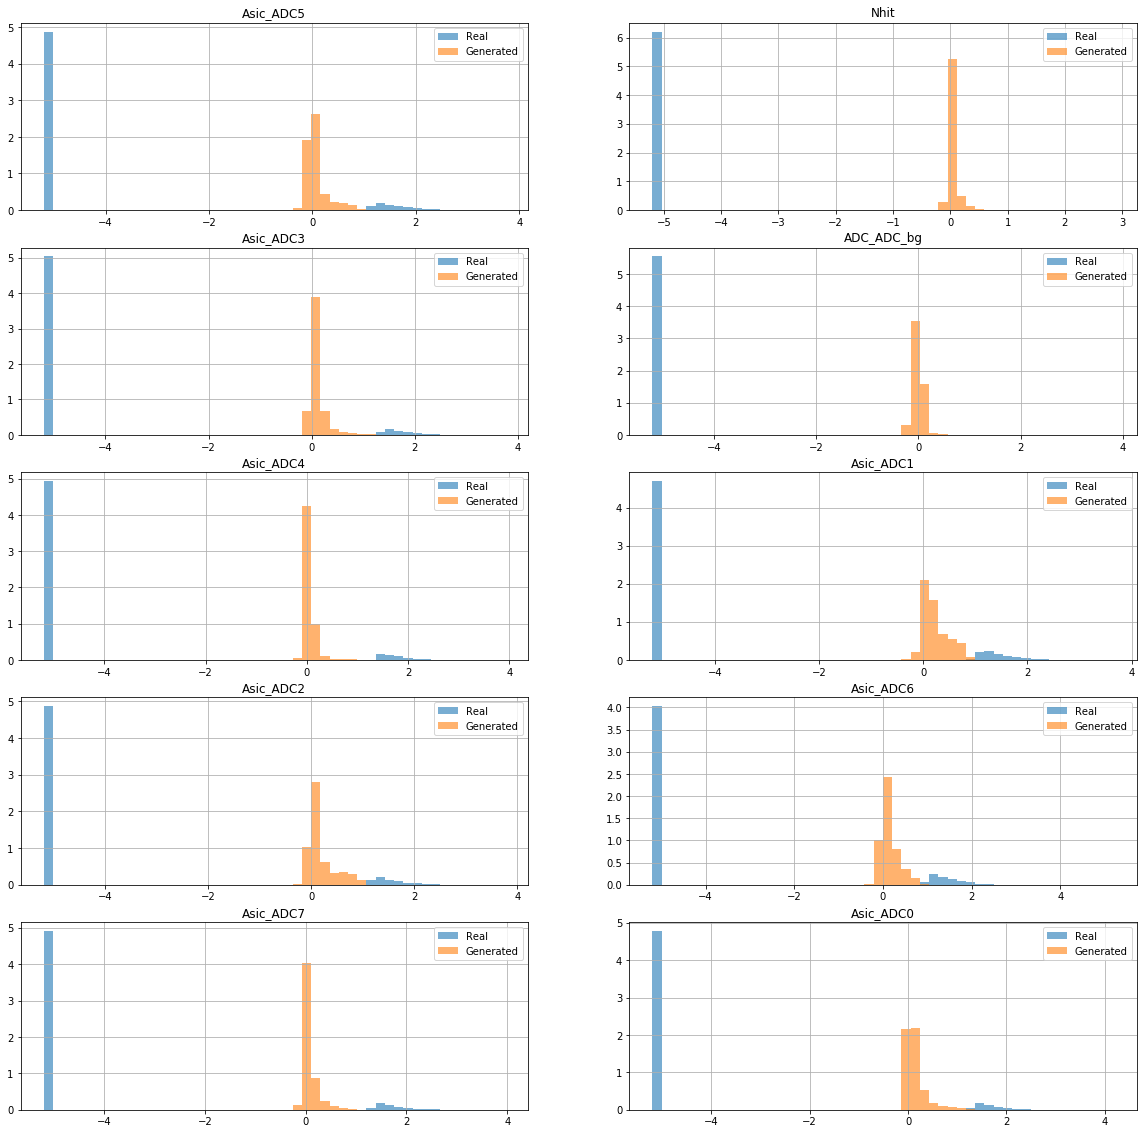

<Figure size 1440x1440 with 0 Axes>

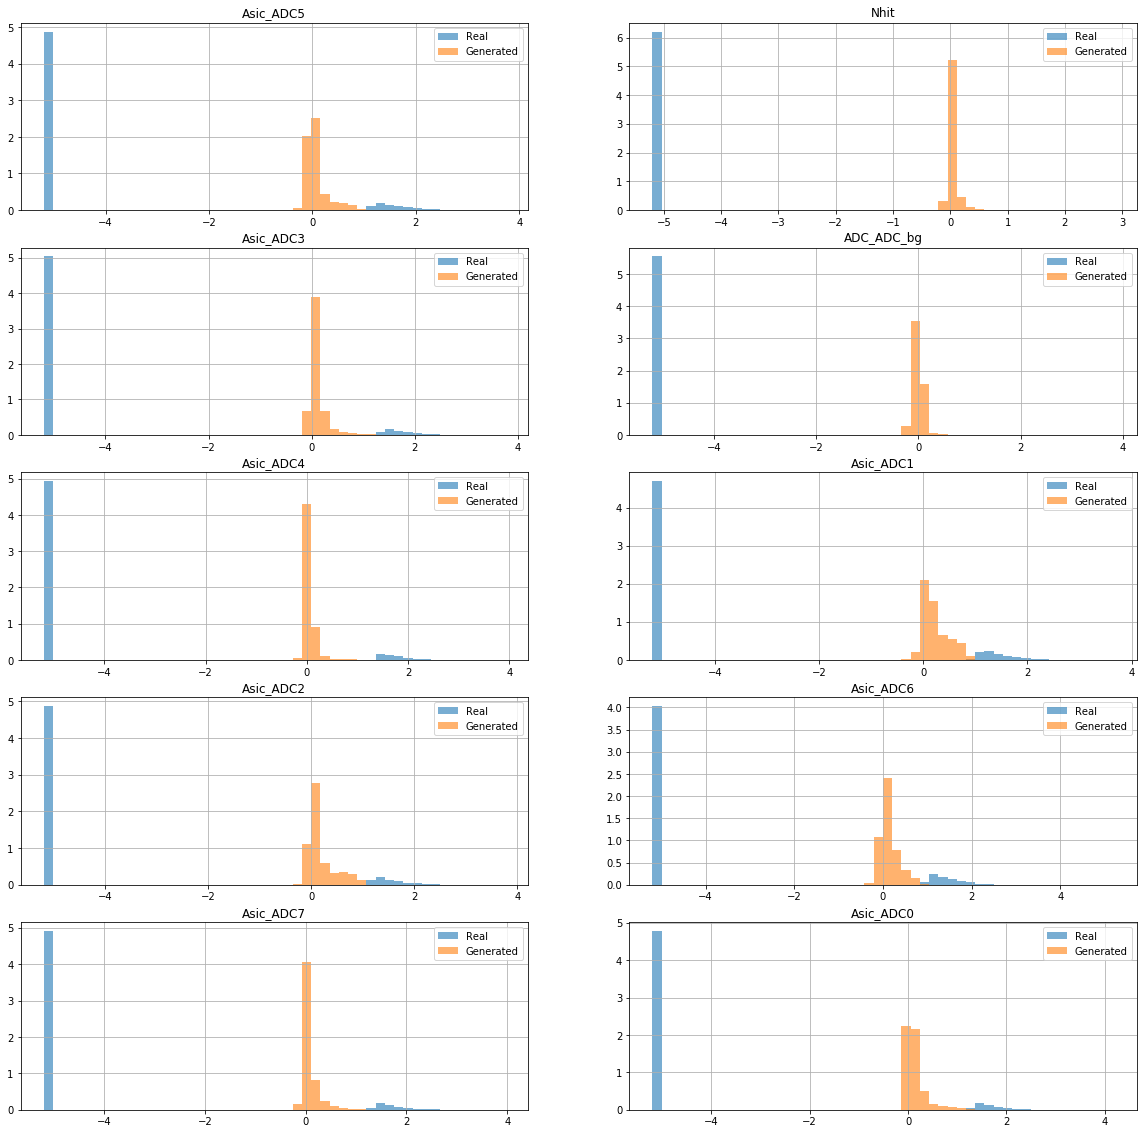

<Figure size 1440x1440 with 0 Axes>

Error in callback <function flush_figures at 0x7fb814799d90> (for post_execute):


KeyboardInterrupt: 

In [21]:
for iteration in tqdm(range(1000000), position=0, leave=True):
    
    if iteration % VAL_INTERVALS == 0:
        model.eval()
        experiment.log_metrics({'gen/lr': gen_optimizer.param_groups[0]['lr'],
                                'disc/lr': disc_optimizer.param_groups[0]['lr']},
                               step=iteration)

        gen_scheduler.step()
        disc_scheduler.step()
        
        plot_compare(mc_noct)
        experiment.log_figure('no_ct', step=iteration)
        plot_compare(mc_ct)
        experiment.log_figure('yes_ct', step=iteration)
        plt.clf()
    
    model.train()
    # gen update
    for _ in range(GEN_UPDATES):
        x, context = [i.to(device).float() for i in next(train_dataloader)]
        gen_optimizer.zero_grad()
        gen_loss = model.calculate_loss_gen(x, context=context).mean()
        gen_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        gen_optimizer.step()
    experiment.log_metric('train/gen/loss', gen_loss.item(), step=iteration)

    # disc update
    for _ in range(DISC_UPDATES):
        x, context = [i.to(device).float() for i in next(train_dataloader)]
        disc_optimizer.zero_grad()
        disc_loss = model.calculate_loss_disc(x, context=context).mean()
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        disc_optimizer.step()
    experiment.log_metric('train/disc/loss', disc_loss.item(), step=iteration)
    

(array([8.7117e+04, 2.0000e+00, 0.0000e+00, 6.3000e+01, 6.0600e+02,
        4.6870e+03, 3.1330e+03, 2.3870e+03, 1.4200e+03, 5.8500e+02]),
 array([-1. ,  0.2,  1.4,  2.6,  3.8,  5. ,  6.2,  7.4,  8.6,  9.8, 11. ]),
 <a list of 10 Patch objects>)

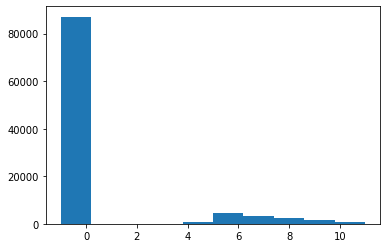

In [29]:
plt.hist(mc_noct[x_cols].iloc[:, 0])

(array([8.7117e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 6.5000e+01, 1.0813e+04, 2.0050e+03]),
 array([-5.19933758, -4.40119202, -3.60304647, -2.80490091, -2.00675535,
        -1.20860979, -0.41046423,  0.38768132,  1.18582688,  1.98397244,
         2.782118  ]),
 <a list of 10 Patch objects>)

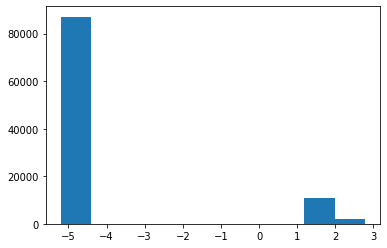

In [31]:
plt.hist(x_scaler.transform(mc_noct[x_cols])[:, 0])

In [ ]:
    plt.figure(figsize=(20, 20))
    
    x_val = x_scaler.transform(data[x_cols])
    c_val = c_scaler.transform(data[c_cols])
    x_gen = model.generate(data.shape[0], torch.tensor(c_val, device=device).float()).detach().cpu().numpy()
    
    plot_ind = 0
    for ind, col in enumerate(x_cols):
        if 'ADC' in col or col == 'Nhit':
            plot_ind += 1
            plt.subplot(5, 2, plot_ind)
            _, bins, _ = plt.hist(x_val[:, ind], bins=50, alpha=0.6, label='Real', density=True)
            plt.hist(x_gen[:, ind], bins=bins, alpha=0.6, label='Generated', density=True)
            plt.grid()
            plt.legend()
            plt.title(col)

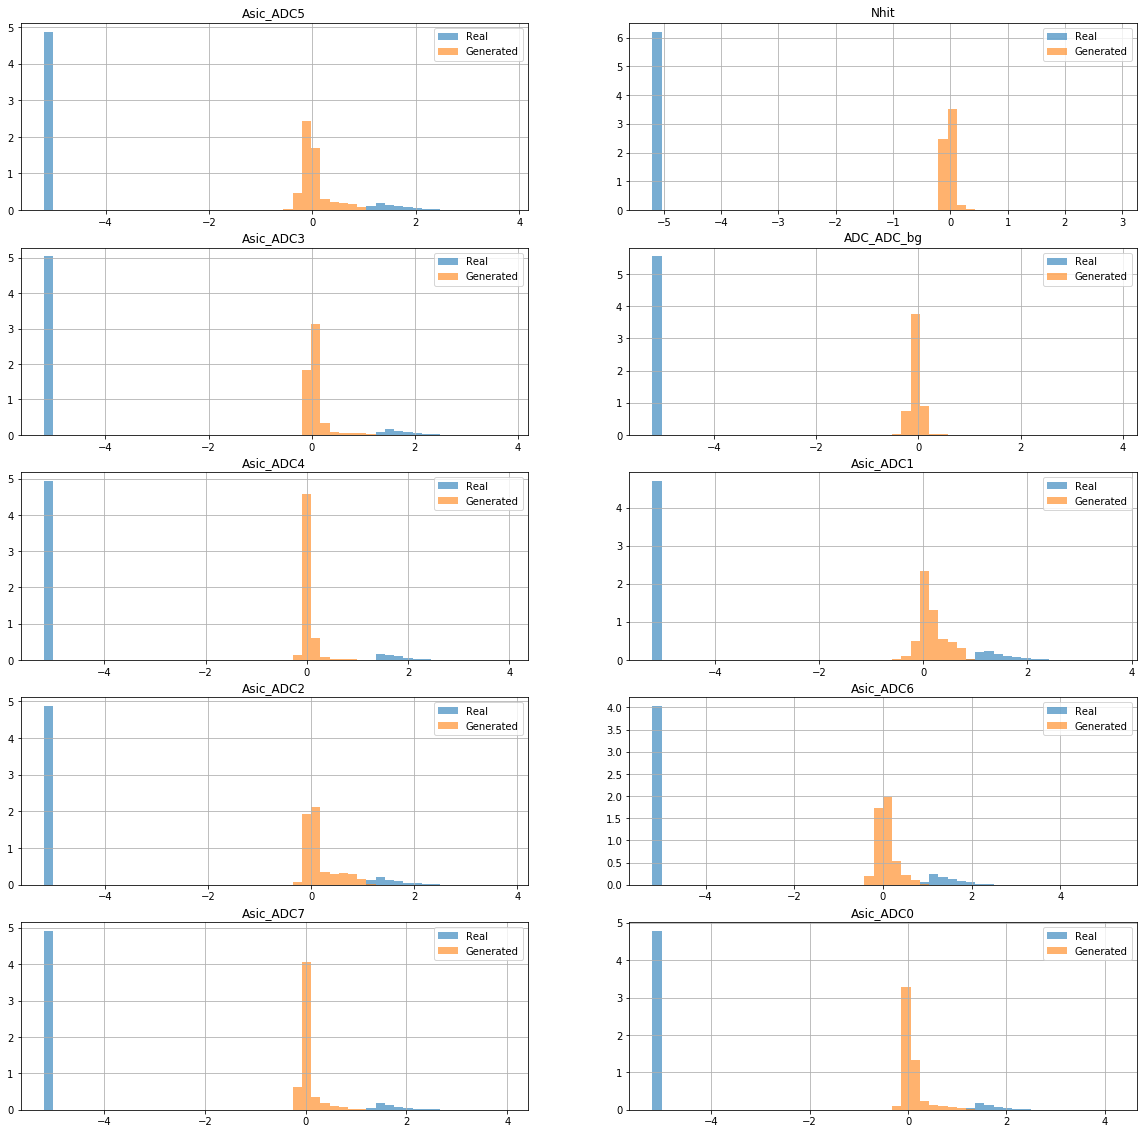

In [24]:
plot_compare(mc_noct)

In [23]:
torch.save(model.state_dict(), os.path.join('../saved_models/', 'first_wgan' + '.state_dict'))


In [22]:
1

1

In [ ]:
mc_noct = pd.read_csv('../data/raw/mcmc_noxtalk.csv.gz', nrows=100000)
plot_compare(mc_noct)

In [ ]:
mc_ct = pd.read_csv('../data/raw/mcmc_xtalk.csv.gz', nrows=100000)
plot_compare(mc_ct)